In [ ]:
! pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = 'True')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from rouge import Rouge
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#train.csv
train_df = pd.read_csv('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022/Data/train.csv')

In [ ]:
#validation csv
val_df = pd.read_csv('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022/Data/validation.csv')

In [ ]:
#test csv
test_df = pd.read_csv('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022/Data/test.csv')

In [ ]:
print('train:',train_df.shape, '\nvalidation:', val_df.shape,'\ntest:', test_df.shape)

train: (287113, 3) 
validation: (13368, 3) 
test: (11490, 3)


In [ ]:
test_df.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


## Checking Null Values

In [ ]:
train_df.isna().sum()

id            0
article       0
highlights    0
dtype: int64

## Checking Duplicates

In [ ]:
train_df.duplicated(subset=['article', 'highlights']).sum()

3098

In [ ]:
train_df = train_df.drop_duplicates(subset= ['article', 'highlights'])

In [ ]:
train_df = train_df.drop(['id'], axis = 1)
train_df = train_df.reset_index(drop=True)

In [ ]:
val_df = val_df.drop(['id'], axis = 1)
val_df = val_df.reset_index(drop=True)

In [ ]:
test_df = test_df.drop(['id'], axis = 1)
test_df = test_df.reset_index(drop=True)

In [ ]:
test_df.head(1)

,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...


In [ ]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
        
    return text

In [ ]:
clean_summaries = []
for summary in train_df.highlights:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete!')
    
clean_texts = []
for text in train_df.article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete!')

Cleaning Summaries Complete!
Cleaning Texts Complete!


In [ ]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:50000]
clean_df['summary'] = clean_summaries[:50000]

In [ ]:
clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')

In [ ]:
clean_df.head(1)

,text,summary
0,associated press published 14 11 est 25 octobe...,<sostok> bishop john folda of north dakota i...


## Tokenizing Text

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.2, random_state=0)

In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

In [ ]:
thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  58.71725900913791
Total Coverage of rare words:  1.145932566348828
Text Vocab:  86560


In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

In [ ]:
thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  71.7848544042157
Total Coverage of rare words:  4.193647255910229
Summary Vocab:  18633


In [ ]:
maxlen_text = 800
maxlen_summ = 150

In [ ]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))

In [ ]:
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

In [ ]:
train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [ ]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))

In [ ]:
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

In [ ]:
train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [ ]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (40000, 800)
Target Values Shape (40000, 150)
Test Sequence (10000, 800)
Target Test Shape (10000, 150)


## Pretrained Embedding

In [ ]:
embeding_index = {}
embed_dim = 100
with open('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [ ]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [ ]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

## Model Architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 100)     8656000     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 256),        234496      ['embedding[0][0]']              
                                 (None, 128),                                                 

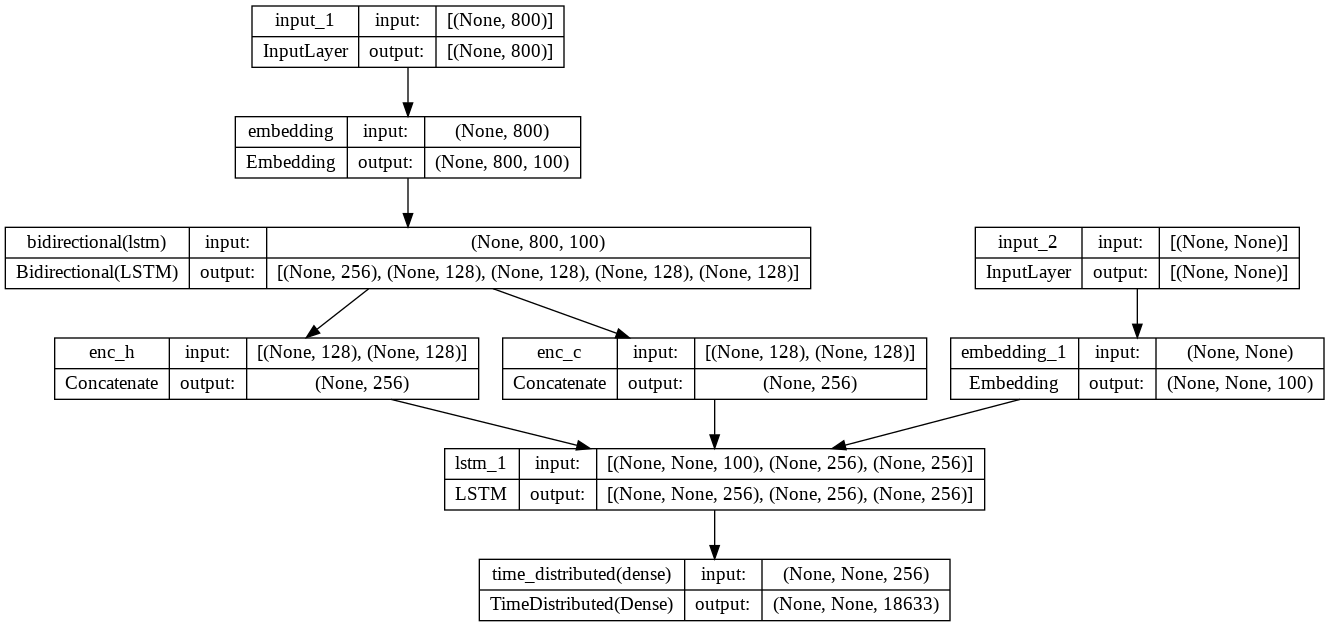

In [ ]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='/content/drive/MyDrive/Statistical Software - MSDS Fall 2022/Data/seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=5, callbacks=[early_stop], batch_size=128, verbose=1, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/5
313/313 [==============================] - 365s 1s/step - loss: 2.4923 - val_loss: 2.1752
Epoch 2/5
313/313 [==============================] - 347s 1s/step - loss: 2.1243 - val_loss: 2.0437
Epoch 3/5
313/313 [==============================] - 348s 1s/step - loss: 2.0281 - val_loss: 1.9759
Epoch 4/5
313/313 [==============================] - 344s 1s/step - loss: 1.9697 - val_loss: 1.9350
Epoch 5/5
313/313 [==============================] - 354s 1s/step - loss: 1.9277 - val_loss: 1.9047


## Inference

In [ ]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [ ]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq

In [ ]:
test_inputs = [clean_text(sent) for sent in test_df.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
hyps = []
with open('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022/Data/result_50000.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(500):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_df.article[i], test_df.highlights[i], our_summ])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


## ROUGE SCORE

In [ ]:
rouge = Rouge()
rouge.get_scores(hyps, test_df.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.07121477166728102,
  'p': 0.29107051557840785,
  'f': 0.10907480141680202},
 'rouge-2': {'r': 0.009603876550131537,
  'p': 0.03311238463415487,
  'f': 0.013815002135558124},
 'rouge-l': {'r': 0.06890850619615435,
  'p': 0.28252208971118936,
  'f': 0.10555431561683003}}